# Demo

In [184]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import time
import os
import pickle
import datetime
import tonic
import matplotlib.pyplot as plt

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
criterion = torch.nn.BCELoss(reduction="sum") # loss not divided by output size

In [190]:
class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, bias=True, logit0=-2, theta0=0, log_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__() 
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))

    def forward(self, theta):
        #print(self.theta0)
        p0 = torch.sigmoid(self.logit0)
        #out = p0 / 2 + (1 - p0) * torch.sigmoid(self.linear(theta))
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0 )/torch.exp(self.log_wt))
        #print(out)
        return out

In [186]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

In [187]:
def fit_data(
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [188]:
N = 256
# batch_size = N//4
# batch_size = N//2

N_cv = 8

seed = 1973
N_scan = 9
N_test = N * 8 # number of points for validation

bias = True

p0 = 0.1
theta0 = 0.0
wt = np.pi / 16
theta_std = np.pi / 2

def psychometric_function(theta, p0=p0, theta0=theta0, wt=wt):
    return p0 / 2 + (1 - p0) / (1 + np.exp(-(theta - theta0) / wt))

def get_data(N=N, p0=p0, theta0=theta0, wt=wt, theta_std=theta_std, seed=seed, **kwargs):
    np.random.seed(seed)
    # theta = np.random.randn(N)*theta_std
    theta = (2 * np.random.rand(N) - 1) * theta_std

    p = psychometric_function(theta, p0, theta0, wt)

    y = np.random.rand(N) < p  # generate data
    return theta, p, y

In [191]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.44894
Iteration: 16 - Loss: 0.44210
Iteration: 32 - Loss: 0.43629
Iteration: 48 - Loss: 0.43148
Iteration: 64 - Loss: 0.42764
Iteration: 80 - Loss: 0.42468
Iteration: 96 - Loss: 0.42245
Iteration: 112 - Loss: 0.42082
Iteration: 128 - Loss: 0.41966
Iteration: 144 - Loss: 0.41884
Iteration: 160 - Loss: 0.41825
Iteration: 176 - Loss: 0.41783
Iteration: 192 - Loss: 0.41752
Iteration: 208 - Loss: 0.41728
Iteration: 224 - Loss: 0.41709
Iteration: 240 - Loss: 0.41694
Iteration: 256 - Loss: 0.41680
Iteration: 272 - Loss: 0.41669
Iteration: 288 - Loss: 0.41659
Iteration: 304 - Loss: 0.41651
Iteration: 320 - Loss: 0.41643
Iteration: 336 - Loss: 0.41637
Iteration: 352 - Loss: 0.41631
Iteration: 368 - Loss: 0.41627
Iteration: 384 - Loss: 0.41622
Iteration: 400 - Loss: 0.41619
Iteration: 416 - Loss: 0.41616
Iteration: 432 - Loss: 0.41613
Iteration: 448 - Loss: 0.41611
Iteration: 464 - Loss: 0.41609
Iteration: 480 - Loss: 0.41607
Iteration: 496 - Loss: 0.41606
Iteration: 512 -

In [192]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 1.571


In [193]:
def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.item() # -logistic_model.linear.bias.item() / logistic_model.linear.weight.item()
    wt_ = torch.exp(logistic_model.log_wt).item() # 1 / logistic_model.linear.weight.item()
    p0_ = torch.sigmoid(logistic_model.logit0).item()

    if verbose:
        if bias:
            print(f"theta0 = {theta0_:.3f}")
        print(f"slope = {wt_:.3f}")
        print(f"p0 = {p0_:.3f}")
    return theta0_, wt_, p0_

theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = -0.011
slope = 0.246
p0 = 0.143


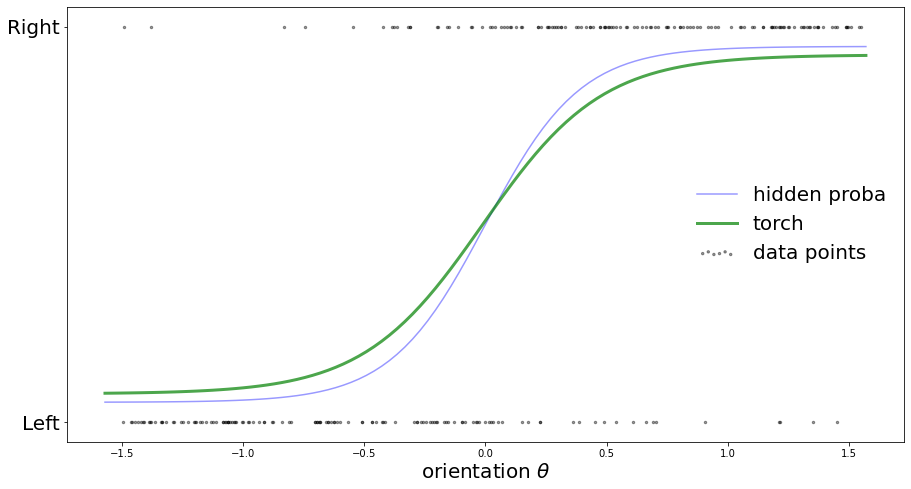

In [194]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(theta, y, s=6, alpha=0.4, color="k", label="data points")
# ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-theta_std, theta_std, 100)[:, None]
y_values_p = psychometric_function(x_values, p0, theta0, wt)
ax.plot(x_values, y_values_p, alpha=0.4, color="b", label="hidden proba")
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, "g", alpha=0.7, lw=3, label="torch")
#y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
#ax.plot(x_values, y_values_sk, "r", alpha=0.7, lw=3, label="sklearn")
ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["Left", "Right"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

# HOTS data

In [195]:
def get_nmnist(NbTrainingData, NbTestingData):
    def loadev(nbdigit, loader, learningset):
        timout = []
        xout = []
        yout = []
        polout = []
        labout = []
        for i in range(NbTrainingData):
            events, target = next(iter(loader))
            for iev in range(events.shape[1]):
                    timout.append(events[0][iev][learningset.ordering.find("t")].item())
                    xout.append(events[0][iev][learningset.ordering.find("x")].item())
                    yout.append(events[0][iev][learningset.ordering.find("y")].item())
                    polout.append(events[0][iev][learningset.ordering.find("p")].item())
                    labout.append(target.item())

        eventsout = [xout,yout,timout,polout,labout,learningset.sensor_size,2]
        return eventsout
    
    learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=False,
                                    transform=None)
    loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
    events_train = loadev(NbTrainingData, loader, learningset)
    events_test = loadev(NbTestingData, loader, learningset)
    
    return events_train, events_test

#### Building matrix for logistic regression
def gather_data(events_in,
                tau_cla=150, # characteristic time of a digit
                sample_events=50, sample_space = 1,
                verbose=False, debug=False):
    tau_cla *= 1e3 # to enter tau in ms
    n_events = len(events_in[0])

    c_int = lambda n, d : ((n - 1) // d) + 1
    
    data = np.zeros((c_int(events_in[-2][0], sample_space),
                     c_int(events_in[-2][1], sample_space),
                     events_in[-1])) #tmp data

    X = np.zeros((c_int(n_events, sample_events), len(data.ravel())))
    y = np.zeros((c_int(n_events, sample_events), ))

    for i_event in range(1, n_events):
        if events_in[2][i_event]<events_in[2][i_event-1]:
            data = np.zeros((c_int(events_in[-2][0], sample_space),
                     c_int(events_in[-2][1], sample_space),
                     events_in[-1])) #tmp data 

        data *= np.exp(-(events_in[2][i_event]-events_in[2][i_event-1])/tau_cla)
        
        x_pos = events_in[0][i_event]//sample_space
        y_pos = events_in[1][i_event]//sample_space
        p = events_in[3][i_event]
        data[int(x_pos), int(y_pos), int(p)] = 1.

        if i_event % sample_events == sample_events//2 :
            if debug:
                print(f'DEBUG {i_event} {i_event//sample_events} ')
                print(f'DEBUG {y[i_event//sample_events]}   ')
                print(f'DEBUG  {events_in[-3][i_event]} ')
            X[i_event//sample_events, :] = data.ravel()
            y[i_event//sample_events] = events_in[-3][i_event]
            
    if verbose: print('Number of events: ' + str(X.shape[0])+' - Number of features: ' + str(X.shape[1]))

    return X, y

def get_events(tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test):
    hotshom = network(krnlinit=krnlinit, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
    arch = [hotshom.L[i].kernel.shape[1] for i in range(len(hotshom.L))]
    fname = f'{records_path}/EXP_03_NMNIST/{timestr}_hots_{dataset}_{arch}_{tau}_{homeo}_{sigma}_{homeinv}_{jitter}'
    print(fname)
    if not os.path.isfile(fname+'_model.pkl'):
        loaderhom, order = hotshom.learning1by1(dataset=dataset)
        with open(fname+'_model.pkl', 'wb') as file:
            pickle.dump([hotshom, loaderhom, order], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+'_model.pkl', 'rb') as file:
            hotshom, loaderhom, order = pickle.load(file)
            
    if not os.path.isfile(fname+f'_evout_{nb_train}_{nb_test}.pkl'):       
        _, loaderhom, out_train = hotshom.running(loaderhom, order, nb_digit = nb_train, LR=True)
        _, loaderhom, out_test = hotshom.running(loaderhom, order, nb_digit = nb_test, LR=True)
        with open(fname+f'_evout_{nb_train}_{nb_test}.pkl', 'wb') as file:
            pickle.dump([out_train, out_test], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+f'_evout_{nb_train}_{nb_test}.pkl', 'rb') as file:
            out_train, out_test = pickle.load(file)
    return out_train, out_test

def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

In [196]:
dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2020-12-21'
verbose = True

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
krnlinit = 'first'
nblay = 3
nbclust = 4

ds = 75
nb_train = 7500//ds
nb_test = 2500//ds


In [226]:
#for multiclass
criterion = torch.nn.NLLLoss(reduction='sum')

class MultinomialLogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, Npix, Nclass, bias=True):
        super(MultinomialLogisticRegressionModel, self).__init__()
        self.theta = torch.nn.Parameter(torch.random(Npix,Nclass))
        
    def forward(self, x):
        softmax = torch.exp(torch.matmul(x,self.theta))
        softmax /= torch.sum(softmax,axis=1)
        return softmax

In [224]:
def fit_data(
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    logistic_model = MultinomialLogisticRegressionModel(theta.shape[1],10)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [164]:
tic()
events_train, events_test = get_nmnist(nb_train, nb_test)
toc()

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/
Done in 46.033 s


In [165]:
tic()
X_train, y_train = gather_data(events_train, sample_events=50, sample_space = 1, verbose=verbose)
toc()

Number of events: 8179 - Number of features: 2312
Done in 2.723 s


In [227]:
%%timeit
#theta, y = torch.tensor(X_train), torch.tensor(y_train)
logistic_model, loss = fit_data(X_train, y_train, verbose=False)

TypeError: 'module' object is not callable

In [217]:
a = torch.rand(10,5)
b = torch.ones(10)
c = torch.tensor(np.array([1,2,3,4,5]))
print(b, torch.sum(a,axis=1))
print(b/torch.sum(a,axis=1))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) tensor([3.0129, 1.7919, 2.5452, 2.0941, 2.4828, 2.1953, 3.1291, 2.8940, 2.9257,
        2.7944])
tensor([0.3319, 0.5581, 0.3929, 0.4775, 0.4028, 0.4555, 0.3196, 0.3455, 0.3418,
        0.3579])
